In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from PrayTimes import prayTimes
import requests
from bs4 import BeautifulSoup

In [154]:
def get_flight_history(flight_number):
    url = 'https://www.flightaware.com/live/flight/' + flight_number + '/history'
    hist_link = []
    # Define headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.164 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the link with the specific pattern
        for link in soup.find_all('a'):
            href = link.get('href')
            if href and '/history/2' in href:
                hist_link = hist_link + ['https://www.flightaware.com' + href]
                print('https://www.flightaware.com' + href)


    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
    #print(hist_link)
    print(hist_link[0])


    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " \
                      "AppleWebKit/537.36 (KHTML, like Gecko) " \
                      "Chrome/114.0.0.0 Safari/537.36"
        }
    url = hist_link[-1]+"/tracklog"
    print(url)
    resp = requests.get(url, headers = headers)
    resp.raise_for_status()  # Raise error on bad response

    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find_all('table')
    df = pd.read_html(str(table))
    return df

In [155]:
def Parse24HrTime(time_24hr):
    if time_24hr[0] == '-':
        hr = 0
        mins = 0
    else:  
        hr = int(time_24hr.split(":")[0])
        mins = int(time_24hr.split(":")[1])

    
    return(hr, mins)

def Extract24HrTime(time_12hr):
    exc_day = time_12hr[-2:]
    exc_time = time_12hr[:-3]
    hr = int(exc_time.split(":")[0])
    mins = int(exc_time.split(":")[1])
    
    if exc_day == 'PM':
        if hr != 12:
            hr += 12
    else:
        if hr == 12:
            hr = 0
    
    return(hr, mins)

def ConvertTo12Hr(time_24):
    mins = (time_24 - int(time_24))*60
    hrs = int(time_24)
    if hrs > 12:
        day = 'PM'
        hrs -= 12
    elif hrs == 12:
        day = 'PM'
        hrs = hrs
    elif hrs == 0:
        day = 'AM'
        hrs += 12
    else:
        day = 'AM'
    return(hrs, mins, day)

In [156]:
pd_flighthistory = get_flight_history('PIA798')

https://www.flightaware.com/live/flight/PIA798/history/20250719/0110Z/CYYZ/OPLA
https://www.flightaware.com/live/flight/PIA798/history/20250712/0310Z/CYYZ/OPLA
https://www.flightaware.com/live/flight/PIA798/history/20250719/0110Z/CYYZ/OPLA
https://www.flightaware.com/live/flight/PIA798/history/20250712/0310Z/CYYZ/OPLA/tracklog


In [160]:
df = pd_flighthistory[0]

In [13]:
prayTimes.setMethod('Jafari') #paramaterS: MWL, ISNA, Egypt, Makkah, Karachi, Tehran, Jafari


In [149]:
df.index[0]

0

In [161]:
# cleanup:
df = df[~df['LatitudeLat'].str.contains('FlightAware')]
df = df[~df['LatitudeLat'].str.contains('Gander')]
df = df[~df['LatitudeLat'].str.contains('Surface')]
df = df[~df['LatitudeLat'].str.contains('Estimated')]
df = df.iloc[:-1]

# Todo: stop before the last row, or remove the last row.


In [162]:
#df = pd_flighthistory[0]
date = (2025, 7, 11)
#CalculationMethod.
format = "%I:%M %p"



NumRecords = len(df)
#print(NumRecords)
longitudes = np.zeros(NumRecords)
latitudes = np.zeros(NumRecords)
fajr_times = np.zeros(NumRecords)
dhuhr_times = np.zeros(NumRecords)
maghrib_times = np.zeros(NumRecords)
sunrise_times = np.zeros(NumRecords)

flight_times = np.zeros(NumRecords)
end_row = df['LatitudeLat'].str.contains('Surface').count()


ind = 0
#for ind_rec in np.arange(1 , NumRecords):
for ind_rec, row in df.iterrows():
    height = 35000
    loc_latitude = float(df.LatitudeLat[ind_rec][:6])
    loc_longitude = float(df.LongitudeLon[ind_rec][:6])
    coordinates = (loc_latitude, loc_longitude, height)
    # date = df.date
    #prayer_times = PrayerTimes(coordinates, date, calculation_parameters=params)
    prayer_times = prayTimes.getTimes(date, coordinates, -4)#calculation_parameters=params)

    #prayer_times = PrayerTimes(coordinates, df.date[ind_rec], calculation_parameters=params)

    dhuhr_time = prayer_times['dhuhr']#.astimezone(tz).strftime(format)
    maghrib_time = prayer_times['maghrib']#.astimezone(tz).strftime(format)
    fajr_time = prayer_times['fajr']#.astimezone(tz).strftime(format)
    sunrise_time = prayer_times['sunrise']#.astimezone(tz).strftime(format)
    
    ext_hr_flight, ext_mins_flight = Extract24HrTime(df['Time (EDT)EDT'][ind_rec][4:])
    ext_hr_dhuhr, ext_mins_dhuhr = Parse24HrTime(dhuhr_time)
    ext_hr_fajr, ext_mins_fajr = Parse24HrTime(fajr_time)
    ext_hr_sunrise, ext_mins_sunrise = Parse24HrTime(sunrise_time)

    ext_hr_maghrib, ext_mins_maghrib = Parse24HrTime(maghrib_time)

    
    flight_times[ind] = ext_hr_flight + ext_mins_flight/60
    fajr_times[ind] = ext_hr_fajr + ext_mins_fajr/60
    sunrise_times[ind] = ext_hr_sunrise + ext_mins_sunrise/60

    dhuhr_times[ind] = ext_hr_dhuhr + ext_mins_dhuhr/60
    maghrib_times[ind] = ext_hr_maghrib + ext_mins_maghrib/60
    
    longitudes[ind] = loc_longitude
    latitudes[ind] = loc_latitude
    ind +=1
    


ValueError: could not convert string to float: 'Fri 11'

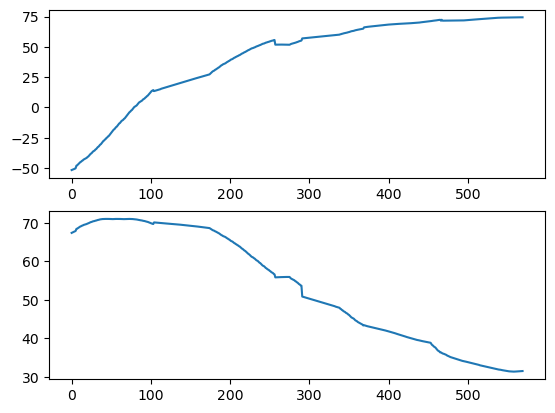

In [159]:
fig, ax = plt.subplots(2)
ax[0].plot(longitudes)
ax[1].plot(latitudes)


Dhuhr Time is at (5, 23.000000000000025, 'AM')
Maghrib Time is at (1, 11.0, 'AM')
Fajr Time is at (1, 11.0, 'AM')
Sunrise Time is at (1, 11.0, 'AM')


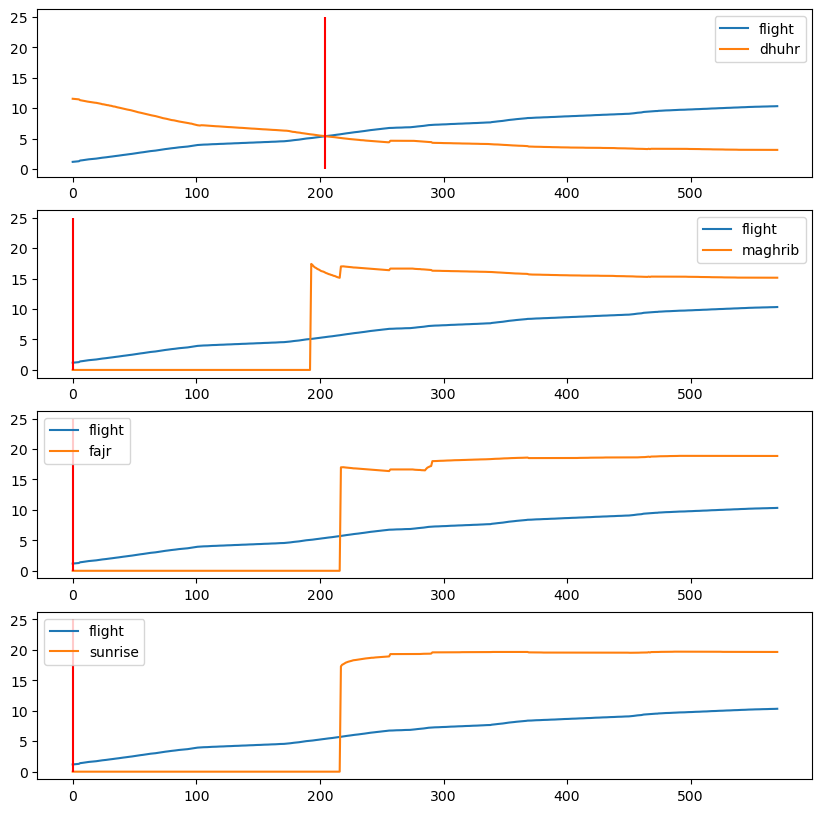

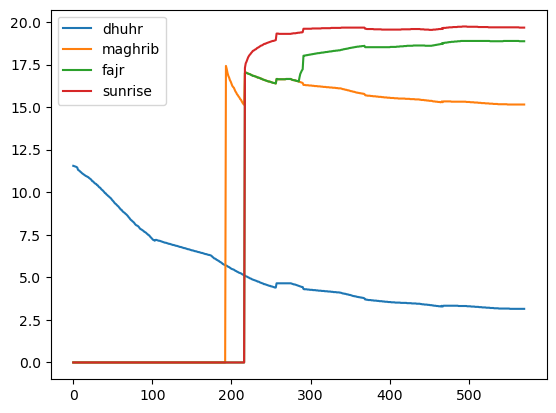

In [145]:
maghrib_times = maghrib_times #+ 20/60 # Shia correction
diff_dhuhr = np.abs(dhuhr_times - flight_times)
diff_maghrib = np.abs(maghrib_times - flight_times)
diff_fajr = np.abs(fajr_times - flight_times)
diff_sunrise = np.abs(sunrise_times - flight_times)

fig, ax = plt.subplots(4, figsize= (10,10) )
ax[0].plot(flight_times)
ax[1].plot(flight_times)
ax[2].plot(flight_times)
ax[3].plot(flight_times)


ax[0].plot(dhuhr_times)
#ax[0].plot(diff_dhuhr)
ax[1].plot(maghrib_times)
#ax[1].plot(diff_maghrib)
ax[2].plot(fajr_times)
#ax[2].plot(diff_fajr)
ax[3].plot(sunrise_times)

ax[0].legend(['flight', 'dhuhr'])#, 'diff_dhuhr'])
ax[1].legend(['flight', 'maghrib'])#, 'diff_maghrib'])
ax[2].legend(['flight', 'fajr'])#, 'diff_fajr'])
ax[3].legend(['flight', 'sunrise'])
ax[0].vlines(np.argmin(diff_dhuhr), 0 ,25, color = 'Red')
ax[1].vlines(np.argmin(diff_maghrib), 0 ,25, color = 'Red')
ax[2].vlines(np.argmin(diff_fajr), 0 ,25, color = 'Red')
ax[3].vlines(np.argmin(diff_sunrise[:-20]), 0 ,25, color = 'Red')
            
print(f'Dhuhr Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_dhuhr)])}')
print(f'Maghrib Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_maghrib)])}')
print(f'Fajr Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_fajr)])}')
print(f'Sunrise Time is at {ConvertTo12Hr(flight_times[np.argmin(diff_sunrise[:-20])])}')

fig, ax = plt.subplots()
ax.plot(dhuhr_times)
ax.plot(maghrib_times)
ax.plot(fajr_times)
ax.plot(sunrise_times)
ax.legend(['dhuhr', 'maghrib', 'fajr', 'sunrise'])

In [60]:
len(df)

578

In [69]:
np.arange(1,3)

array([1, 2])

In [73]:
df.to_csv('test.csv')

In [30]:
pd_flighthistory[1]

,0
0,Your browser is unsupported. upgrade your browser


# Debug

In [68]:
ind_rec = 3
height = 35000
print(df.LatitudeLat[ind_rec])
print(df.LongitudeLon[ind_rec])
coordinates = (df.LatitudeLat[ind_rec], df.LongitudeLon[ind_rec], height)
print(coordinates)



67.633367.63
-51.0833-51.08
('67.633367.63', '-51.0833-51.08', 35000)


In [75]:
# Need to clean df
int(-71.34*100)/100

-71.34

In [92]:
int(df.LongitudeLon[ind_rec][:6]*100)/100

KeyError: 6

In [94]:
ind_rec = 5
float(df.LongitudeLon[ind_rec][:7])

-50.566

In [97]:
df.LongitudeLon[7]

'-50.2101-50.21'

In [151]:
df.to_csv('test.csv')

In [138]:
df = df[~df['LatitudeLat'].str.contains('FlightAware')]
df = df[~df['LatitudeLat'].str.contains('Gander')]
df = df[~df['LatitudeLat'].str.contains('Surface')]
df = df[~df['LatitudeLat'].str.contains('Estimated')]



578

In [56]:
df

,Time (EDT)EDT,LatitudeLat,LongitudeLon,CourseDir,kts,mph,feet,Rate,Reporting Facility
1,Sat 01:11:46 AM01:11AM,67.433367.43,-51.6333-51.63,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
2,Sat 01:12:46 AM01:12AM,67.533367.53,-51.3833-51.38,↗ 44°,490,564,3.300033e+09,NaN,Gander Center
3,Sat 01:13:46 AM01:13AM,67.633367.63,-51.0833-51.08,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
4,Sat 01:14:46 AM01:14AM,67.716767.72,-50.8333-50.83,↗ 49°,490,564,3.300033e+09,NaN,Gander Center
5,Sat 01:15:47 AM01:15AM,67.816767.82,-50.5667-50.57,↗ 45°,490,564,3.300033e+09,12.0,Gander Center
...,...,...,...,...,...,...,...,...,...
582,Sat 10:19:30 AM10:19AM,31.466931.47,74.403674.40,↑ 1°,157,181,1.900190e+07,-773.0,FlightAware ADS-B (LHE / OPLA)
583,Sat 10:19:46 AM10:19AM,31.479131.48,74.403874.40,↑ 1°,157,181,1.675168e+07,-814.0,FlightAware ADS-B (LHE / OPLA)
584,Sat 10:20:05 AM10:20AM,31.493031.49,74.404074.40,↑ 1°,157,181,1.425142e+07,-814.0,FlightAware ADS-B (LHE / OPLA)
585,Sat 10:20:21 AM10:20AM,31.505331.51,74.404374.40,↑ 1°,156,180,1.200120e+07,-844.0,FlightAware ADS-B (LHE / OPLA)


In [42]:
df['LatitudeLat']

0                                          Gander Center
1                                           67.433367.43
2                                           67.533367.53
3                                           67.633367.63
4                                           67.716767.72
                             ...                        
583                                         31.479131.48
584                                         31.493031.49
585                                         31.505331.51
586                                          FlightAware
587    Sat 10:21:09 AM10:21AM Arrival (LHE) @ Saturda...
Name: LatitudeLat, Length: 588, dtype: object